# Conditional object generation using pre-trained models and plug-in networks
Prowadzący: **Patryk Wielopolski**, Politechnika Wrocławska

Abstrakt: Modele generatywne przyciągnęły uwagę wielu praktyków uczenia maszynowego w ostatnich latach, co zaowocowało modelami takimi jak StyleGAN do generowania ludzkiej twarzy lub PointFlow do generowania chmur punktów 3D. Jednak domyślnie nie możemy kontrolować jego procesu próbkowania, tj. nie możemy wygenerować próbki z określonym zestawem atrybutów. Obecne podejście polega na przekwalifikowaniu modelu z dodatkowymi danymi wejściowymi i inną architekturą, co wymaga czasu i zasobów obliczeniowych.

Podczas tego praktycznego warsztatu omówimy metodę, która pozwala nam generować obiekty o danym zestawie atrybutów bez ponownego uczenia modelu bazowego. W tym celu wykorzystamy modele normalizing flows – Conditional Masked Autoregressive Flow i Conditional Real NVP oraz sieci Plugin, w wyniku których powstaje Flow Plugin Network.


Cel warsztatów:
 * Praktyczne zapoznanie się z modelami Normalizing Flows oraz biblioteką nflows
 * Praktyczne zapoznanie się z metodą Flow Plugin Network

Agenda:
 * Wstęp do modeli generatywnych
 * Praktyczny wstęp do Normalizing Flows z wykorzystaniem pakietu **nflows**.
 * Metoda Flow Plugin Network (FPN)
 * Wykorzystanie metody FPN do warunkowego generowania obrazów

## Wstęp do modeli generatywnych

## Modele dyskryminatywne vs. modele generatywne

**Model dyskryminatywny** jest modelem warunkowego prawdopodobieństwa ${P(Y\mid X=x)}$ zmiennej celu Y, biorąc pod uwagę obserwację x.
*Przykłady*: Regresja Logistyczna, Drzewa decyzyjne.

**Model generatywny** to model statystyczny wspólnego rozkładu prawdopodobieństwa ${P(X, Y)}$ na danej zmiennej obserwowalnej X i zmiennej docelowej Y.
*Przykłady*:

![](figures/three-generative-models.png)

## Normalizing Flows

 Normalizing Flows reprezentują grupę modeli generatywnych, które można efektywnie trenować poprzez bezpośrednią estymację wiarogodności dzięki zastosowaniu wzoru na zmianę zmiennej. W praktyce wykorzystują one szereg (parametrycznych) funkcji odwracalnych: $\mathbf{y}=\mathbf{f}_n \circ \dots \circ \mathbf{f}_1(\mathbf{z})$. Zakładając, że dany rozkład bazowy $p(\mathbf{z})$ dla $\mathbf{z}$, log likelihood dla $\mathbf{y}$ jest podane przez $\log p(\mathbf{y}) = \ log p(\mathbf{z}) - \sum_{n=1}^N \log \left| \det \frac{\partial \mathbf{f}_n}{\partial \mathbf{z}_{n-1}} \right|$. W praktycznych zastosowaniach $p(\mathbf{y})$ reprezentuje rozkład obserwowalnych danych, a $p(\mathbf{z})$ jest zwykle zakładany jako rozkład normalny z niezależnymi komponentami.



![](figures/normalizing-flow.png)

# Praktyczny wstęp do Normalizing Flows z wykorzystaniem pakietu **nflows**

Omówienie modeli:
  * NICE
  * RealNVP
  * MAF

Omówienie warunkowych modeli:
  * Conditional NICE
  * Conditional RealNVP
  * Conditional MAF

### Konstrukcja biblioteki nflows

Krótkie omówienie biblioteki

  * Distributions - Bazowe rozkłady prawdopodobieństwa
  * Flows - Przykładowe implementacje modeli normalizing flows
  * Nn - Implementacje sieci neuronowych budujących bloki modelu
  * Transforms - Implementacje bloków transformujących w normalazing flows
  * Utils

### Toy example data

In [ ]:
!pip install matplotlib nflows sklearn torch torchvision

In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

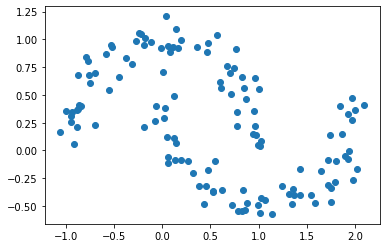

In [2]:
x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1]);

# NICE (Non-linear Independent Component Estimation)

Model NICE (Non-linear Independent Component Estimation) implementuje model normalizing flows poprzez układanie w stos sekwencji odwracalnych bijektywnych funkcji transformacji. W każdej bijekcji, znanej jako additive coupling layer, wymiary wejściowe są podzielone na dwie części:

 - Pierwsze wymiary pozostają takie same;
 - Druga część, do wymiarów, podlega transformacji addytywnej, tj. dodawany jest komponent przesunięcia.
$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} + \mu(\mathbf{x}_{1:d})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= \mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d})
\end{cases}
$$

In [14]:
import torch
import torch.optim as optim
import torch.nn.functional as F

from nflows.distributions.normal import StandardNormal
from nflows.flows.base import Flow
from nflows.nn import nets as nets
from nflows.transforms.base import CompositeTransform
from nflows.transforms.coupling import AdditiveCouplingTransform
from nflows.transforms.normalization import BatchNorm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


class NICE(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AdditiveCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [4]:
nice = NICE(features=2, hidden_features=4, num_layers=1, num_blocks_per_layer=1)

In [5]:
# Sprawdźmy komponenty modelu
nice

NICE(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AdditiveCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=1, out_features=4, bias=True)
          (blocks): ModuleList(
            (0): ResidualBlock(
              (linear_layers): ModuleList(
                (0): Linear(in_features=4, out_features=4, bias=True)
                (1): Linear(in_features=4, out_features=4, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=4, out_features=1, bias=True)
        )
      )
    )
  )
  (_distribution): StandardNormal()
  (_embedding_net): Identity()
)

In [81]:
nice = NICE(features=2, hidden_features=4, num_layers=4, num_blocks_per_layer=2)
nice_opt = optim.Adam(nice.parameters())

In [82]:
def train(model, opt, num_iter=5000, iter_log=5000):
    for i in range(num_iter):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32)
        opt.zero_grad()
        loss = -model.log_prob(inputs=x).mean()
        loss.backward()
        opt.step()

        if (i + 1) % iter_log == 0:
            xline = torch.linspace(-1.5, 2.5, 100)
            yline = torch.linspace(-.75, 1.25, 100)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                zgrid = model.log_prob(xyinput).exp().reshape(100, 100)

            plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
            plt.title('iteration {}'.format(i + 1))
            plt.show()

In [ ]:
train(nice, nice_opt, num_iter=10000, iter_log=1000)

# Ćwiczenie (5 min.)

Modyfikując hiperparametry modelu wytrenuj model, który lepiej odwzoruje prawdziwy rozkład danych.

In [84]:
# TODO: Your code goes here.

### Badanie podstawowych funkcjonalności modeli
#### Samplowanie

In [85]:
x, y = datasets.make_moons(128, noise=.1)
x = torch.tensor(x, dtype=torch.float32)

In [86]:
samples = nice.sample(1000).detach().numpy()

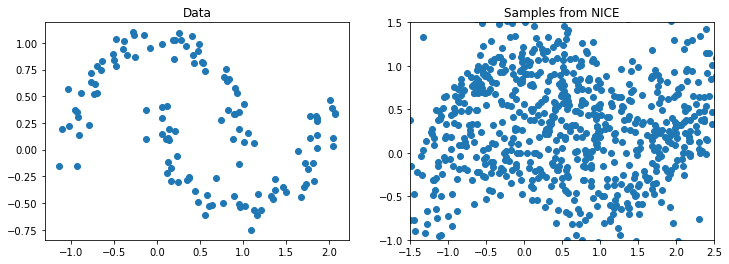

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(x[:, 0], x[:, 1])
ax[0].set_title('Data')

ax[1].scatter(samples[:, 0], samples[:, 1])
ax[1].set_title('Samples from NICE')

plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.show()

# RealNVP

Model RealNVP (Real-valued Non-Volume Preserving) jest rozszerzeniem modelu NICE, które opiera się na warstwie znanej jako Affine Coupling Layer. Analogicznie do modelu NICE, wymiary wejściowe są podzielone na dwie części:

 - Pierwsze wymiary pozostają takie same;
 - Druga część, do wymiarów, podlega transformacji afinicznej („scale-and-shift”) i zarówno parametry skali, jak i przesunięcia są funkcjami pierwszych wymiarów.

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} \odot \exp{(\sigma{(\mathbf{x}_{1:d})})} + \mu(\mathbf{x}_{1:d})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= (\mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d})) \odot \exp{(-\sigma{(\mathbf{u}_{1:d})})}
\end{cases}
$$


# Ćwiczenie (5 min.)

Na podstawie powyższego kodu modelu NICE oraz biblioteki nflows zaimplementuj model RealNVP.

In [ ]:
# HINT: from nflows.transforms import ...


class RealNVP(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AdditiveCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )

In [89]:
real_nvp = RealNVP(features=2, hidden_features=4, num_layers=2, num_blocks_per_layer=2)
real_nvp_opt = optim.Adam(real_nvp.parameters())

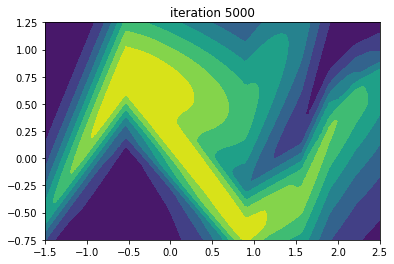

In [90]:
train(real_nvp, real_nvp_opt)

### Dalsze badanie podstawowych funkcjonalności modeli
#### Transformacje

In [91]:
prior_samples = real_nvp._distribution.sample(1000)

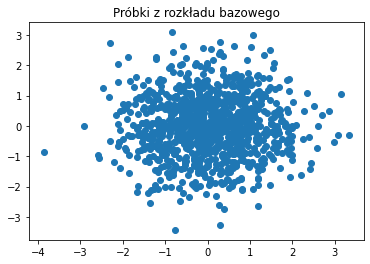

In [92]:
prior_samples_numpy = prior_samples.detach().numpy()

plt.scatter(prior_samples_numpy[:, 0], prior_samples_numpy[:, 1])
plt.title('Próbki z rozkładu bazowego')
plt.show()

In [93]:
nf_blocks = real_nvp._transform._transforms
nf_blocks

ModuleList(
  (0): AffineCouplingTransform(
    (transform_net): ResidualNet(
      (initial_layer): Linear(in_features=1, out_features=4, bias=True)
      (blocks): ModuleList(
        (0): ResidualBlock(
          (linear_layers): ModuleList(
            (0): Linear(in_features=4, out_features=4, bias=True)
            (1): Linear(in_features=4, out_features=4, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): ResidualBlock(
          (linear_layers): ModuleList(
            (0): Linear(in_features=4, out_features=4, bias=True)
            (1): Linear(in_features=4, out_features=4, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (final_layer): Linear(in_features=4, out_features=2, bias=True)
    )
  )
  (1): AffineCouplingTransform(
    (transform_net): ResidualNet(
      (initial_layer): Linear(in_features=1, out_features=4, bias=True)
      (blocks): ModuleList(
        (0): ResidualBlo

In [94]:
for transform in nf_blocks:
    print(transform)

AffineCouplingTransform(
  (transform_net): ResidualNet(
    (initial_layer): Linear(in_features=1, out_features=4, bias=True)
    (blocks): ModuleList(
      (0): ResidualBlock(
        (linear_layers): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): ResidualBlock(
        (linear_layers): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layer): Linear(in_features=4, out_features=2, bias=True)
  )
)
AffineCouplingTransform(
  (transform_net): ResidualNet(
    (initial_layer): Linear(in_features=1, out_features=4, bias=True)
    (blocks): ModuleList(
      (0): ResidualBlock(
        (linear_layers): ModuleList(
          (0): Linear(in_features=4

In [95]:
consequitive_samples = [prior_samples]
current_sample = prior_samples

for transform in nf_blocks:
    current_sample, _ = transform(current_sample)
    consequitive_samples.append(current_sample)

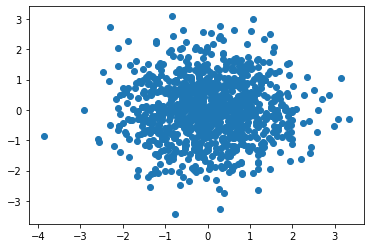

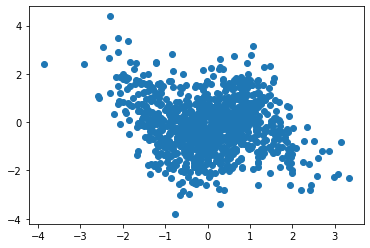

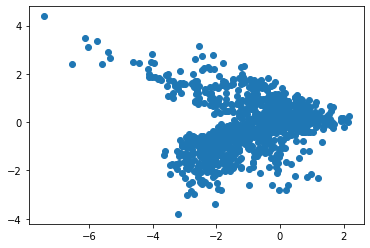

In [96]:
for s in consequitive_samples:
    s = s.detach().numpy()
    plt.scatter(s[:, 0], s[:, 1])
    plt.show()

# Masked Autoregressive Flow (MAF)

#TODO: Opis

$$p(\mathbf{x}) = \Pi^{N}_{i=1} p(x_i|\mathbf{x}_{1:i-1}) \textit{,}$$
gdzie
$$p(x_i|\mathbf{x}_{1:i-1}) = \mathcal{N}(x_i|\mu_i, (\exp{(\alpha_i)})^2 \textit{,}$$
gdzie $\mu_i = f_{\mu_i}(\mathbf{x_{1:i-1}})$ i $\alpha_i = f_{\alpha_i}(\mathbf{x_{1:i-1}})$


Przykładowo: $p(x_1, x_2) = p(x_1)p(x_2|x_1)$, gdzie $p(x_1) = \mathcal{N}(x_1|0, 4)$ i $p(x_2|x1) = \mathcal{N}(x_2|x_1^2, 1)$.

In [66]:
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation, ReversePermutation


class MaskedAutoregressiveFlow(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            num_layers=2,
            num_blocks_per_layer=2,
            use_residual_blocks=True,
            use_random_masks=False,
            use_random_permutations=False,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        if use_random_permutations:
            permutation_constructor = RandomPermutation
        else:
            permutation_constructor = ReversePermutation

        layers = []
        for _ in range(num_layers):
            layers.append(permutation_constructor(features))
            layers.append(
                MaskedAffineAutoregressiveTransform(
                    features=features,
                    hidden_features=hidden_features,
                    num_blocks=num_blocks_per_layer,
                    use_residual_blocks=use_residual_blocks,
                    random_mask=use_random_masks,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=batch_norm_within_layers,
                )
            )
            if batch_norm_between_layers:
                layers.append(BatchNorm(features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [117]:
maf = MaskedAutoregressiveFlow(features=2, hidden_features=16, num_layers=4)
maf_opt = optim.Adam(maf.parameters())

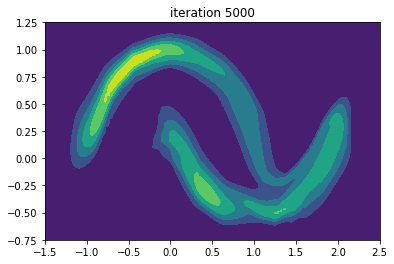

In [118]:
train(maf, maf_opt)

# Ćwiczenie (5 min.)

Zweryfikuj jak wyglądają kolejne transformacje modelu MAF analogicznie do przykładu RealNVP.

In [113]:
# TODO: Your code goes here.

# Przerwa (10 min.)

# Conditional NICE

#TODO: Opis

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} + \mu(\mathbf{x}_{1:d}, \mathbf{c})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= \mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d}, \mathbf{c})
\end{cases}
$$

In [119]:
class cNICE(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,  # New component
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                context_features=context_features,  # New component
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AdditiveCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [123]:
c_nice = cNICE(features=2, hidden_features=8, num_layers=4, context_features=1)
c_nice_opt = optim.Adam(c_nice.parameters())

In [124]:
def train_conditional(model, opt, num_iter=5000, iter_log=5000):
    for i in range(num_iter):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)  # New
        opt.zero_grad()
        loss = -model.log_prob(inputs=x, context=y).mean()  # New
        loss.backward()
        opt.step()

        if (i + 1) % iter_log == 0:
            fig, ax = plt.subplots(1, 2, figsize=(12, 8))
            xline = torch.linspace(-1.5, 2.5, 100)
            yline = torch.linspace(-.75, 1.25, 100)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                zgrid0 = model.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
                zgrid1 = model.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

            ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
            ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
            fig.suptitle('iteration {}'.format(i + 1))
            plt.show()

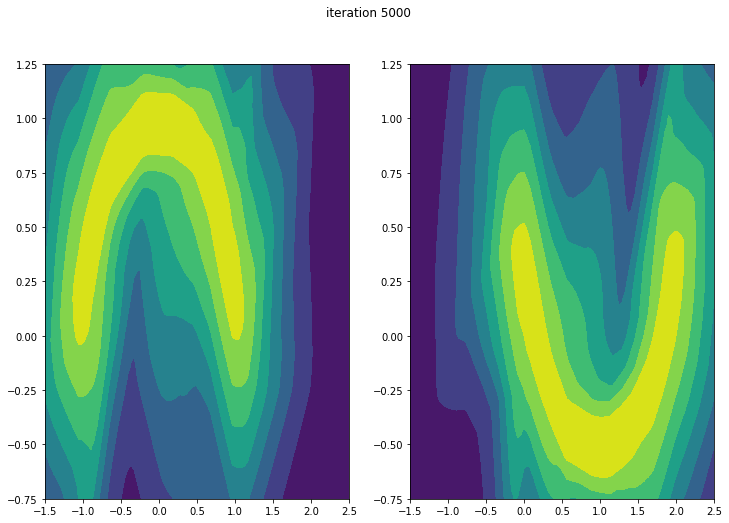

In [125]:
train_conditional(c_nice, c_nice_opt)

# Ćwiczenie (5 min.)

Wygeneruj próbki z modelu Conditional NICE dla górnego oraz dolnego półksiężyca

In [126]:
# TODO: Your code goes here.

# Ćwiczenie (10 min.)

Stwórz model Conditional RealNVP oraz model Conditional MAF analogicznie do poprzedniego przykładu. Wytrenuj przykładowe modele.

# Conditional RealNVP

$$
\begin{cases}
    \mathbf{u}_{1:d} &= \mathbf{x}_{1:d} \\
    \mathbf{u}_{d+1:D} &= \mathbf{x}_{d+1:D} \odot \exp{(\sigma{(\mathbf{x}_{1:d}, \mathbf{c})})} + \mu(\mathbf{x}_{1:d}, \mathbf{c})
    \end{cases}
    \Leftrightarrow
    \begin{cases}
    \mathbf{x}_{1:d} &= \mathbf{u}_{1:d} \\
    \mathbf{x}_{d+1:D} &= (\mathbf{u}_{d+1:D} - \mu(\mathbf{u}_{1:d}, \mathbf{c})) \odot \exp{(-\sigma{(\mathbf{u}_{1:d}, \mathbf{c}))}}
\end{cases}
$$

In [104]:
from nflows.transforms import AffineCouplingTransform


class cRealNVP(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,
            num_layers=2,
            num_blocks_per_layer=2,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        mask = torch.ones(features)
        mask[::2] = -1

        def create_resnet(in_features, out_features):
            return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks_per_layer,
                activation=activation,
                dropout_probability=dropout_probability,
                use_batch_norm=batch_norm_within_layers,
            )

        layers = []
        for _ in range(num_layers):
            transform = AffineCouplingTransform(mask=mask, transform_net_create_fn=create_resnet)
            layers.append(transform)
            mask *= -1
            if batch_norm_between_layers:
                layers.append(BatchNorm(features=features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )

In [127]:
c_real_nvp = cRealNVP(features=2, hidden_features=4, context_features=1)
c_real_nvp_opt = optim.Adam(c_real_nvp.parameters())

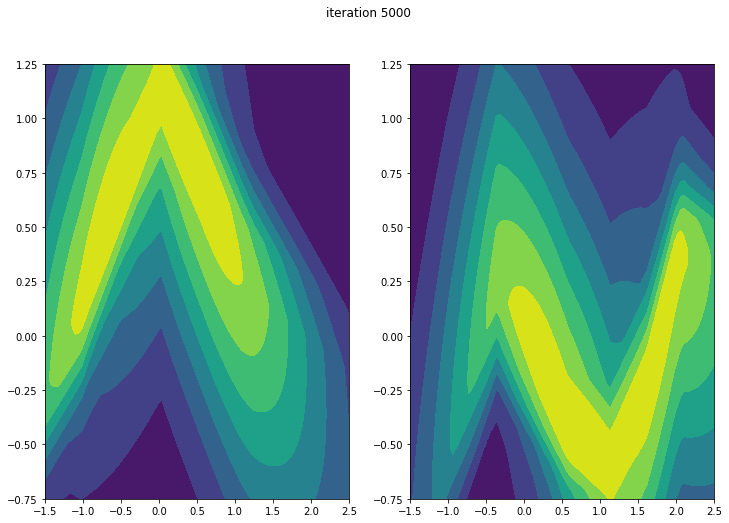

In [128]:
train_conditional(c_real_nvp, c_real_nvp_opt)

# Conditional Masked Autoregressive Flow (MAF)

$$p(\mathbf{x} | \mathbf{c}) = \Pi^{N}_{i=1} p(x_i|\mathbf{x}_{1:i-1}, \mathbf{c}) \textit{,}$$
gdzie
$$p(x_i|\mathbf{x}_{1:i-1}, \mathbf{c}) = \mathcal{N}(x_i|\mu_i, (\exp{(\alpha_i)})^2 \textit{,}$$
gdzie $\mu_i = f_{\mu_i}(\mathbf{x_{1:i-1}}, \mathbf{c})$ i $\alpha_i = f_{\alpha_i}(\mathbf{x_{1:i-1}}, \mathbf{c})$


In [64]:
class cMaskedAutoregressiveFlow(Flow):
    def __init__(
            self,
            features,
            hidden_features,
            context_features,
            num_layers=2,
            num_blocks_per_layer=2,
            use_residual_blocks=True,
            use_random_masks=False,
            use_random_permutations=False,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        if use_random_permutations:
            permutation_constructor = RandomPermutation
        else:
            permutation_constructor = ReversePermutation

        layers = []
        for _ in range(num_layers):
            layers.append(permutation_constructor(features))
            layers.append(
                MaskedAffineAutoregressiveTransform(
                    features=features,
                    hidden_features=hidden_features,
                    context_features=context_features,
                    num_blocks=num_blocks_per_layer,
                    use_residual_blocks=use_residual_blocks,
                    random_mask=use_random_masks,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=batch_norm_within_layers,
                )
            )
            if batch_norm_between_layers:
                layers.append(BatchNorm(features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )


In [108]:
c_maf = cMaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
c_maf_opt = optim.Adam(c_maf.parameters())

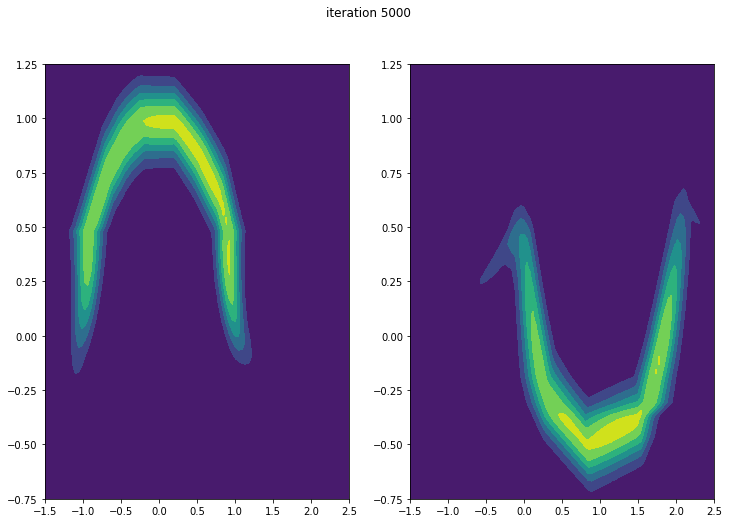

In [109]:
train_conditional(c_maf, c_maf_opt)

## Metoda Flow Plugin Network (FPN)

### Koncepcja Plugin Network

![Plugin Network](figures/plugin_koperski.png)

Pomysł:
 - Rozszerzenie istniejącej sieci neuronowej bez dodatkowego treningu, np. gdy pojawią się dane z dodatkową informację (eng. partial evidence)

Założenia koncepcji:
 - Nie przetrenowujemy oryginalnej sieci lecz jedynie trenujmy komponent plugin
 - Czas predykcji modelu jest jedynie nieznacznie większy

### Koncepcja Flow Plugin Network

 - Rozszerzenie Plugin Networku do modeli generatywnych
 - Wykorzystuje jako model bazowy - VAE
 - Wykorzystuje Conditional Normalizing Flows
 - Nie przetrenowujemy modelu bazowego


![](figures/schema-general.png)

## Trening modelu

### Kodowanie zbioru treningowego do reprezentacji ukrytej
![](figures/schema-training-encode.png)

### Trenowanie modelu Normalizing Flows
![](figures/schema-training-train.png)

## Generowanie próbek

![](figures/schema-sampling.png)

## Manipulowanie cechami obrazu

### Kodowanie obiektu
![](figures/schema-image-manipulation-encoding.png)

### Dekodowanie obiektu
![](figures/schema-image-manipulation-decode.png)

# Wykorzystanie metody FPN do warunkowego generowania obrazów

## Sample z modelu

In [7]:
model = torch.load('models/VAE.pkt')

In [9]:
model

VAE(
  (e_fc1): Linear(in_features=784, out_features=512, bias=True)
  (e_fc2): Linear(in_features=512, out_features=256, bias=True)
  (e_fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=40, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=40, bias=True)
  (d_fc1): Linear(in_features=40, out_features=128, bias=True)
  (d_fc2): Linear(in_features=128, out_features=256, bias=True)
  (d_fc3): Linear(in_features=256, out_features=512, bias=True)
  (d_fc4): Linear(in_features=512, out_features=784, bias=True)
)

In [18]:
def sample_vae(vae, z_dim, n_samples=64):
    with torch.no_grad():
        z = torch.randn(n_samples, z_dim).to(DEVICE)
        return vae.decoder(z).to(DEVICE)

In [19]:
samples = sample_vae(model, z_dim=40, n_samples=64)

In [30]:
from torchvision.utils import save_image

save_image(samples.view(64, 1, 28, 28), f'results/samples_vae.png')

![](results/samples_vae.png)

## Kodowanie danych do latent space'u

In [35]:
import torchvision

batch_size = 500

train_dataset = torchvision.datasets.MNIST(root='data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torchvision.datasets.MNIST(root='data', train=False, transform=torchvision.transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [46]:
import pandas as pd

def get_latent_space(model, loader):
    zs, ys = [], []

    for x, y in loader:
        x = x.view(-1, 28*28)
        zs.append(model.sampling(*model.encoder(x)))
        ys.append(y)
    zs, ys = torch.cat(zs).detach().numpy(), torch.cat(ys).detach().numpy()

    latent_space = pd.DataFrame(zs)
    labels = pd.DataFrame({'y': ys})
    return latent_space, labels

In [47]:
train_latent_space, train_labels = get_latent_space(model, train_loader)
test_latent_space, test_labels = get_latent_space(model, test_loader)

In [48]:
train_latent_space

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.027248,-0.583518,-1.029162,-1.151569,-0.963582,0.697311,-1.157781,-1.137838,-1.241441,1.325491,...,-1.028400,-0.141029,-1.074207,0.106457,-1.460070,0.389605,-1.269105,0.083029,0.161766,-0.422995
1,-1.932675,-0.428417,1.186707,0.111861,0.738516,-0.790186,0.782105,1.173347,-0.494221,-0.799951,...,-0.275575,-0.052351,-1.319491,1.246719,-0.855468,-1.122165,-0.334711,1.615988,-2.072155,-2.470913
2,0.206473,-0.962850,-1.765213,0.198436,-1.074689,-0.296376,-1.223489,-0.869991,-0.290592,-0.254776,...,1.838912,-0.434700,1.216028,0.858284,0.882041,0.546038,0.166523,-0.681812,-0.371145,-0.098158
3,1.192283,0.167978,-1.040200,-0.154143,-1.116292,0.337282,0.860403,-1.632485,-0.379134,-0.739830,...,-1.617216,0.284060,-0.043439,0.715205,-0.949383,-0.106353,0.059263,0.532220,-0.423688,0.841746
4,0.088604,0.906007,-0.238240,-1.101145,1.011498,-0.273716,0.247218,2.455518,-0.789827,2.103284,...,1.006062,-0.532202,-0.740312,-1.156237,1.041415,-0.765550,-0.014985,0.928845,-0.859661,-0.627958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.850858,0.559830,2.152363,0.238654,-0.659782,0.196091,-0.949597,-1.185309,1.952690,0.199338,...,-0.909448,-0.343417,0.478805,1.655630,-0.577852,0.523560,-1.001550,-1.420784,0.130547,2.628836
59996,0.584172,-0.117543,1.006616,-0.174621,-0.064483,-0.460029,0.965264,-0.210699,-0.180755,0.610262,...,-1.754662,0.608921,0.845186,1.484849,0.999662,0.785526,0.992219,1.617557,0.954460,-0.173759
59997,-0.436686,-1.286189,-1.333134,-0.578766,0.730695,-0.272846,1.331989,0.291976,-0.072836,-0.803500,...,-0.228923,0.820535,2.213926,1.842230,1.066411,-0.039689,-1.390970,0.369573,-0.326402,0.376165
59998,-0.399926,-1.073794,-1.039523,1.519921,1.731433,-0.536150,0.052387,0.583968,1.733317,-0.209886,...,-0.629905,-1.325715,0.807658,0.852085,-0.404363,-1.127239,-0.160146,-1.656110,0.324407,0.092861


# Ćwiczenie (5 min.)

Zwizualizuj przestrzeń ukrytą z wykorzystaniem PCA, gdzie kolor będzie oznaczać klasę obiektu.

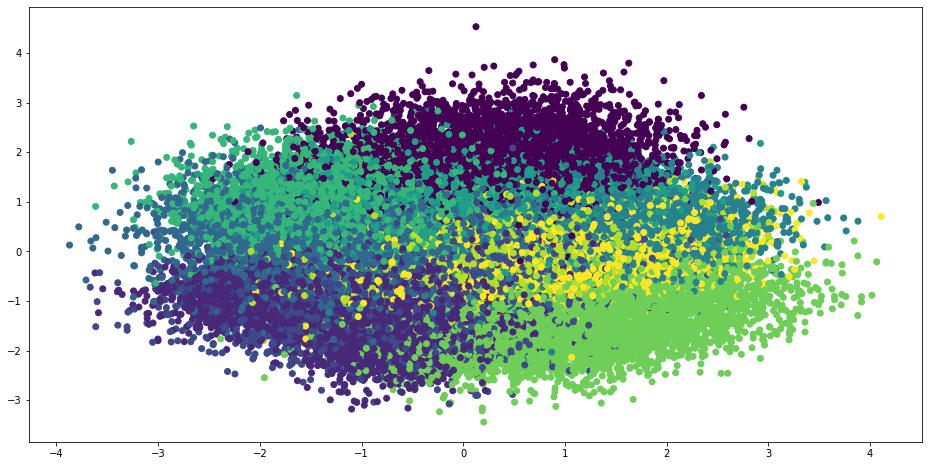

In [52]:
from sklearn.decomposition import PCA

pca = PCA()
s = pca.fit_transform(train_latent_space)

plt.figure(figsize=(16, 8))
plt.scatter(s[:, 0], s[:, 1], c=train_labels['y'])
plt.show()

## Trenowanie modelu

In [62]:
train_labels_ohe = pd.get_dummies(train_labels['y'].astype(str))

In [74]:
flow = cMaskedAutoregressiveFlow(features=40, hidden_features=40, context_features=10, num_layers=5, num_blocks_per_layer=3)
opt = optim.Adam(flow.parameters())

batch_size = 1000
num_epochs = 100

for i in range(num_epochs * (len(train_latent_space) // batch_size)):
    x = train_latent_space.sample(batch_size)
    y = train_labels_ohe.loc[x.index]

    x = torch.tensor(x.values, dtype=torch.float32)
    y = torch.tensor(y.values, dtype=torch.float32)

    opt.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    print(loss.item())
    loss.backward()
    opt.step()

109.74311065673828
108.39512634277344
107.20836639404297
105.98165130615234
104.82826232910156
103.52920532226562
102.2523422241211
100.92500305175781
99.61490631103516
98.23344421386719
96.83102416992188
95.31797790527344
93.62954711914062
91.92023468017578
90.20870208740234
88.35494995117188
86.49822998046875
84.38398742675781
82.50032806396484
80.42820739746094
78.367919921875
76.44190979003906
75.12462615966797
73.78862762451172
72.29019165039062
71.38697052001953
69.34895324707031
67.83504486083984
66.59675598144531
65.46125030517578
64.41468811035156
63.10139465332031
62.58119583129883
62.14643096923828
61.59821701049805
61.366092681884766
61.3907470703125
61.12908172607422
60.81214141845703
60.76411056518555
60.54771041870117
59.69287872314453
60.18146514892578
59.989994049072266
59.80378341674805
59.55196762084961
59.22835922241211
59.321903228759766
59.202938079833984
59.16017150878906
58.788455963134766
58.54014205932617
58.7516975402832
58.617210388183594
58.60861587524414
5

KeyboardInterrupt: 

# Sprawdzamy skuteczność modelu - samplowanie wybranej klasy

In [99]:
num_samples = 64

samples_latent_space_2 = flow.sample(num_samples, context=torch.Tensor([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]))
samples_latent_space_2.shape

torch.Size([1, 64, 40])

In [100]:
samples_2 = model.decoder(samples_latent_space_2.squeeze(0))

In [101]:
samples_2.shape

torch.Size([64, 784])

In [102]:
save_image(samples_2.view(num_samples, 1, 28, 28), f'results/samples_flow_2.png')

![](results/samples_flow_2.png)

# Ćwiczenie

Wygeneruj próbki dla innych klas.

# Inne metody

## PluGeN

### Intuicja

![](figures/PluGeN_a.png) | ![](figures/PluGeN_b.png)

### Metoda

![](figures/PluGeN_schema.png)

## StyleFlow

### Możliwości

![](figures/styleflow_teaser.png)

### Metoda

![](figures/styleflow_schema.png)

# Bibliografia / Przydatne Linki

[Normalizing Flows]()
[Flow based deep generative models](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html#nice)
[NICE]()
[RealNVP]()
[MAF]()
[Flow Plugin Network]()
